---
# FASNet: Face Anti-Spoofing Network
---

From: https://github.com/OeslleLucena/FASNet

A FASNet é uma rede treinada para detecção de ataques spoofing em faces. Essa arquitetura foi baseada na arquitetura da CNN VGG-16, tereinada no ImageNet, alterando-se as últimas camadas totalmente conectadas. No seu treinamento foi realizado um fine-tuning a partir do terceiro bloco. O pré-processaento é explicado em detalhes no artigo submetido ao ICIAR 2017. Basicamente, foi realizado uma detecção de faces em cada imagem e as faces detectadas foram alinhadas em relação ao nariz e os olhos.  

**Organização dos dados nas pastas**:

```
dados/
    treino/
        real/ (Class0)
            001.jpg
            002.jpg
            ...
        ataque/ (Class1)
            001.jpg
            002.jpg
            ...
    validação/
        real/ (Class0)
            001.jpg
            002.jpg
            ...
        ataque/ (Class1)
            001.jpg
            002.jpg
            ...
```

**Arquitetura da FASNet**
![](../figures/FASNetonly.png)


In [1]:
import numpy as np
import os
os.environ['THEANO_FLAGS'] = "device=gpu0,floatX=float32"    
import theano

Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5110)
/opt/conda/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


# Módulos a serem utilizados

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import time
import h5py
import numpy as np
import cv2
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras import optimizers
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import callbacks
from keras import backend as K
from keras.preprocessing.image import load_img,img_to_array
import glob
from sklearn.metrics import confusion_matrix
import sys
sys.path.append('../src')
from my_keras_utilities import TrainingPlotter, load_model_and_history

K.set_image_dim_ordering('th')

Using Theano backend.


## Código para organizar os dados nas pastas

Comandos de shell e script necessário para organização das pastas como mencionado anteriomente. Os dados de valição representam 20% dos dados de treino e são selecionados aleatoriamente.  

In [3]:
!cd /root/REPLAY-FULL-aligned-images;mkdir train val test ;mkdir train/Class0 train/Class1 val/Class0 val/Class1
!mv /root/REPLAY-FULL-aligned-images/testattack /root/REPLAY-FULL-aligned-images/test/
!mv /root/REPLAY-FULL-aligned-images/testreal /root/REPLAY-FULL-aligned-images/test/

In [4]:
from skimage import data,io

def splitTrainVal(n,Train):
    
    nTrueTrain = int(n*Train.shape[0]) 
    idxs = np.random.permutation(Train.shape[0])
    trainIdx, valIdx = idxs[:nTrueTrain], idxs[nTrueTrain:]
    train, val = Train[trainIdx], Train[valIdx]
    
    return train, val

def WriteImageFold(imDirSrc,ImDirDst,lst):
    
    print len(lst)
    
    for imName in lst:
        imName = imName.split('/')[-1]
        filename = os.path.join(imDirSrc,imName)
        try:
            img = io.imread(filename)
        except IOError:
            print "Error: can\'t find file or read data!"
        else:               
            dstFilename = os.path.join(ImDirDst,imName)
            try:
                io.imsave(dstFilename,img)
            except IOError:
                print "Error: can\'t write file or read data!"

trainDataDir = '/root/REPLAY-FULL-aligned-images'

Names = np.array([])
true = np.asarray(glob.glob(os.path.join(trainDataDir, 'trainreal/*.png')))
fake = np.asarray(glob.glob(os.path.join(trainDataDir, 'trainattack/*.png')))

print true.shape
n = 0.8
trainTrue, valTrue = splitTrainVal(n,true)

print trainTrue.shape, valTrue.shape

print fake.shape
n = 0.8
trainFake, valFake = splitTrainVal(n,fake)

print trainFake.shape, valFake.shape

imDir = '/root/REPLAY-FULL-aligned-images'
foldersSrc = ['trainreal','trainattack','trainreal','trainattack']
foldersDst = ['train/Class0','train/Class1','val/Class0','val/Class1']
imDirDst = [os.path.join(imDir,f) for f in foldersDst]
imDirSrc = [os.path.join(imDir,f) for f in foldersSrc]

imNames = [trainTrue,trainFake,valTrue,valFake]
i = 0
for foldD, foldS, im in zip(imDirDst,imDirSrc,imNames):
    print 'Fold', i + 1
    WriteImageFold(foldS,foldD,im)
    i+=1

(10588,)
(8470,) (2118,)
(33174,)
(26539,) (6635,)
Fold 1
8470
Fold 2
26539
Fold 3
2118
Fold 4
6635


# Treinando a FASNet

## Configurações básicas (Caminho, tamanho das entradas, etc)

In [8]:
# Caminho pesos da VGG-16
weights_path = '/root/vgg16_weights.h5'

# Caminho para os pesos da FASNet
model_name  = '/opt/projects/models/FASNetFtWeights18'

# Dimensão das imagens de entrada
img_width, img_height = 96, 96

# Número de camadas em que os pesos ficaram inalterados (congelados) durante o fine-tuning
nFreeze = 18

# Caminho para a pasta de treino
train_data_dir = '/root/REPLAY-FULL-aligned-images/train'

# Caminho para a pasta de validação
validation_data_dir = '/root/REPLAY-FULL-aligned-images/val'

# Número de amostras no treino
nb_train_samples = (8470 + 26539)

# Número de amostras na validação
nb_validation_samples = (2118 + 6635)

# Número de épocas
nb_epoch = 50

## Funções a serem utilizados no treinamento

In [9]:
# Carrega o modelo da VGG-16 com seus devidos pesos sem as camadas totalmente conectadas
def get_tr_vgg_model(weights_path, img_width, img_height):
    
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(3, img_width, img_height)))

    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Carrega os pesos necesários até o último bloco da VGG-15 anterior as camadas densas
    assert os.path.exists(weights_path), 'Model weights not found (see "weights_path" variable in script).'
    f = h5py.File(weights_path)
    for k in range(f.attrs['nb_layers']):
        if k >= len(model.layers):
            break
        g = f['layer_{}'.format(k)]
        weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
        model.layers[k].set_weights(weights)
    f.close()
    print ('Model loaded.')
    
    return model

# Adiciona novas camadas totalmente conecetadas as quais serão utilizadas no fine-tuning
def add_top_layers(model):

    top_model = Sequential()
    top_model.add(Flatten(input_shape=model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))

    model.add(top_model)
    
    return model



# Executa o treino
def run_train(model):
    
    start_time = time.time()
    
    # Congela as camadas até o terceiro bloco da VGG-16
    for layer in model.layers[:nFreeze]:
        layer.trainable = False

    # Compila o modelo
    model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6),
              metrics=['accuracy'])
    
    print ('Model compiled.')
        
    # Aumento de dados para evitar overfitting
    train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip = True,
            fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale=1./255)

    # Leitura dos dados pelo diretório
    train_generator = train_datagen.flow_from_directory(
            train_data_dir,
            target_size=(img_height, img_width),
            batch_size=100,
            class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(
            validation_data_dir,
            target_size=(img_height, img_width),
            batch_size=100,
            class_mode='binary')
    

    print ('\nFine-tuning top layers...\n')

    nepochs = 30
    ploss = 1.0
    
    # Configurando plot dinâmico para o treinamento
    if not os.path.isfile(model_name + '.model'):
        print("[INFO] creating model...")
        # History, checkpoint, earlystop, plot losses:
        my_big_callback = TrainingPlotter(n=1, filepath=model_name, patience=10)
   
    else:
        print("[INFO] loading model...")
        model, my_big_callback = load_model_and_history(model_name)

    past_epochs = my_big_callback.get_nepochs()
    
    fig = plt.figure(figsize=(15,6))
    plt.ylim(0.0, ploss)
    plt.xlim(0, nepochs)
    plt.grid(True)

    if nepochs > 0:
        print("[INFO] training...")
        try:
                # fine-tune the model
                model.fit_generator(
                    train_generator,
                    samples_per_epoch=nb_train_samples,
                    nb_epoch=nb_epoch,
                    validation_data=validation_generator,
                    nb_val_samples=nb_validation_samples,
                    verbose=0,
                    callbacks=[my_big_callback]
                )

        except KeyboardInterrupt:
            pass
    
    print ('\nDone fine-tuning, have a nice day!')
    print("\nExecution time %s seconds" % (time.time() - start_time))
    


Done fine-tuning, have a nice day!

Execution time 14717.9404111 seconds


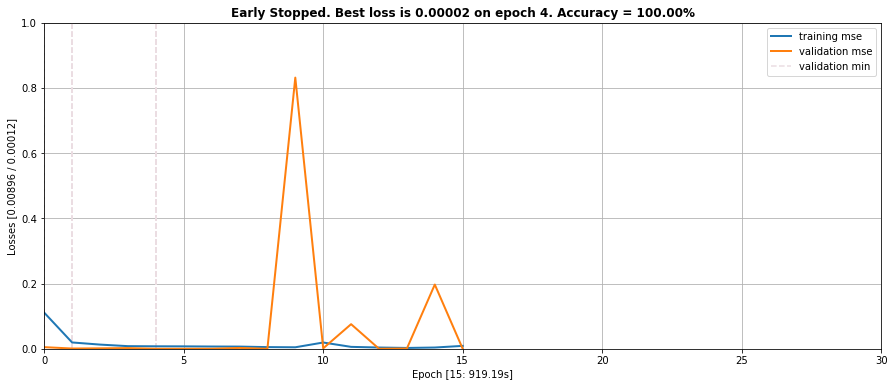

In [10]:
if __name__ == "__main__":
   
    vgg16_tr_model = get_tr_vgg_model(weights_path, img_width, img_height)
    vgg16_tr_model = add_top_layers(vgg16_tr_model)
    
    # Fine-tuning no modelo 
    run_train(vgg16_tr_model)
    


# Test

In [11]:
def load_model(weightsPath,img_width,img_height):
    
    #VGG-16 model
    model = Sequential()
   
    model.add(ZeroPadding2D((1, 1), input_shape=(3, img_width, img_height)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    # Top-model for anti-spoofing
    top_model = Sequential()
    top_model.add(Flatten(input_shape=model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))
    #
    
    model.add(top_model)
    
    if weightsPath:
        model.load_weights(weightsPath)
    else:
        print ('Could not load model!')
    
    return model

def read_preprocess_image(imgPath,img_width,img_height):
      
    img = load_img(imgPath,target_size=(img_width,img_height))
    imgArray = img_to_array(img)
    imgArray = imgArray.reshape(1,3,img_width, img_height)
    imgArray = imgArray/float(255)
    
    return imgArray

## Predição para uma imagem

Imagem Verdadeira!
Imagem Falsa!


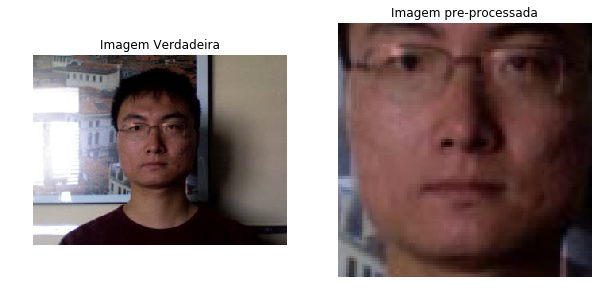

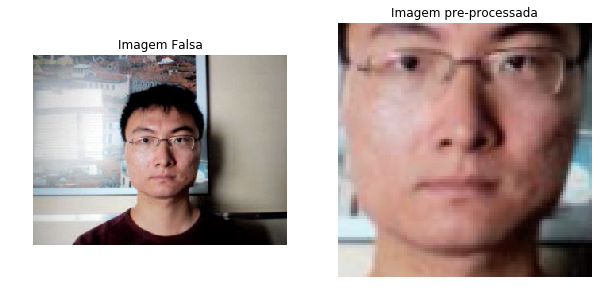

In [14]:
def plot_examples(orig_image, prep_image, name):
    
    size = (10,15)
    
    plt.figure(figsize=size)
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
    plt.title('Imagem ' + name)
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(cv2.cvtColor(prep_image, cv2.COLOR_BGR2RGB))
    plt.title('Imagem pre-processada')
    plt.axis('off')

    plt.show


if __name__ == "__main__":
    
    # Carregamento dos parâmetros
    root = '/root/REPLAY-FULL-aligned-images/test'
    
    prep_true = os.path.join(root,
                             'testreal/client009_session01_webcam_authenticate_adverse_1.mov001.png')
    prep_fake = os.path.join(root,
                             'testattack/fixed_attack_highdef_client009_session01_highdef_photo_adverse.mov001.png')
    
    orig_true = os.path.join('../figures',
                             'real_client009_session01_webcam_authenticate_adverse_1.mov001.jpeg')
    orig_fake = os.path.join('../figures',
                             'fake_fixed_attack_highdef_client009_session01_highdef_photo_adverse.mov001.jpeg')
   
    prep = [prep_true,prep_fake]
    orig = [orig_true,orig_fake]
    
    # Carregamento dos pesos
    model = load_model(model_name + '.model',img_width,img_height)
    
    for i in range(len(prep)):
        
        # Leitura e pré-processamento da imagem
        img = read_preprocess_image(prep[i],img_width,img_height)

        # Predição da Classe
        orig_img = cv2.imread(orig[i])
        
        if (int(model.predict_classes(img,verbose=0)) == 0):
            print ('Imagem Verdadeira!')
            name = 'Verdadeira'
            plot_examples(orig_img,cv2.imread(prep[i]), name) 
        else:
            print ('Imagem Falsa!')
            name = 'Falsa'
            plot_examples(orig_img,cv2.imread(prep[i]), name)          
    

## Resultados para todo o dataset de teste

In [17]:
if __name__ == "__main__":

    start_time = time.time()
    
    # Diretório com as imagens de teste
    testDataDir = '/root/REPLAY-FULL-aligned-images/test'
    
    # Carregamento dos pesos
    model = load_model(model_name + '.model',img_width,img_height)

    testNames = np.array([])
    true = np.asarray(glob.glob(os.path.join(testDataDir, 'testreal/*.png'))) # Class0 igual a real
    fake = np.asarray(glob.glob(os.path.join(testDataDir, 'testattack/*.png'))) # Class1 igual a ataques
    testNames = np.append(true,fake)

    # Predições
    predictions = np.array([])

    for im in testNames:
        img = load_img(im,target_size=(img_width,img_height))
        imgArray = img_to_array(img)
        imgArray = imgArray.reshape(1,3,img_width, img_height)
        imgArray = imgArray/float(255) 
        predictions = np.append(predictions,model.predict_classes(imgArray,batch_size = 50,verbose=0))

    np.save(open('predictionsFT18REPLAY.npy', 'w'), predictions)

    # Gerando os rótulos verdadeiros
    testLabels = np.array([0] * (true.shape[0]) + [1] * (fake.shape[0]))
    
    # Matriz de confusão
    cMat = confusion_matrix(testLabels, predictions)
    FNR = float(cMat[1][0])/(cMat[1][1] + cMat[1][0])
    FPR = float(cMat[0][1])/(cMat[0][0] + cMat[0][1])
    HTER = (FPR + FNR)/2

    print ("Conf. Mat :", cMat)
    print ("ACC =", float(cMat[0,0] + cMat[1,1])/(cMat[0,0] + cMat[1,1] + cMat[1,0] + cMat[0,1]) )
    print ("HTER = %f" % HTER)

    print ('Done!')
    print("\nExecution time %s seconds" % (time.time() - start_time))

('Conf. Mat :', array([[12780,   604],
       [  110, 41730]]))
('ACC =', 0.987070838765754)
HTER = 0.023879
Done!

Execution time 6975.60117888 seconds
